## Librerías necesarias

In [ ]:
import pandas as pd
import scipy.stats as ss
from scipy import stats
from scipy.stats import pearsonr
import itertools
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
import re
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import gensim
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [ ]:
plt.style.use('default')

## Importación del Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arshkon/linkedin-job-postings

import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
linkedin-job-postings.zip: Skipping, found more recently modified local copy (use --force to force download)


BadZipFile: ignored

In [ ]:
base = pd.read_csv("/content/drive/MyDrive/job_postings.csv", sep=",")

In [ ]:
base = base.drop(columns = 'skills_desc' , axis=1)
base = base.drop(columns = 'closed_time' , axis=1)
base = base.drop(columns = 'med_salary' , axis=1)
base = base.drop(columns = 'remote_allowed' , axis=1)
base = base.drop(columns = 'application_type' , axis=1)
base = base.drop(columns = 'currency' , axis=1)
base = base.drop(columns = 'posting_domain' , axis=1)
base = base.drop(columns = 'application_url' , axis=1)
base = base.drop(columns = 'compensation_type', axis=1)
base = base.drop(columns = 'job_posting_url', axis=1)
base = base.drop(columns = 'original_listed_time', axis=1)
base = base.drop(columns = 'listed_time', axis=1)
base = base.drop(columns = 'sponsored', axis=1)
base = base.drop('expiry', axis=1)
base = base.drop('work_type', axis=1)

In [ ]:
# no se va a trabajar con los trabajos a contrato, voluntarios o temporarios
base = base[~((base['formatted_work_type'] == 'Temporary') | (base['formatted_work_type'] == 'Contract') | (base['formatted_work_type'] == 'Volunteer'))]

## Analisis Exploratorio de Datos (EDA)

#### Tratamiento 'title' y 'description'

In [ ]:
base = base.dropna(subset=['description'])

In [ ]:
base = base.rename(columns={'formatted_work_type': 'work_type', 'formatted_experience_level': 'experience_level'})

Se dejan solo las columnas que son pertinentes para el análisis

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_preprocessing(text):
    '''Remove unwanted characters, stopwords, and format the text to create fewer null word embeddings'''

    text = text.lower()
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\(.*?\)|\[.*?\]|\{.*?\}', ' ', text)  # Remove content within parentheses, square brackets, and curly braces
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove numbers
    text = re.sub(r'\b\d+\b', ' ', text)

    # Tokenize the text
    tokens = nltk.WordPunctTokenizer().tokenize(text)

    # Remove short words
    tokens = [word for word in tokens if len(word) > 2]

    # Lemmatize the text
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

In [ ]:
base['title_clean'] = list(map(text_preprocessing, base.title))
base['description_clean'] = list(map(text_preprocessing, base.description))

stopwords_list = stopwords.words('english')
base['title_clean'] = [[word for word in line if word not in stopwords_list] for line in base['title_clean']]
base['description_clean'] = [[word for word in line if word not in stopwords_list] for line in base['description_clean']]

base['title'] = list(map(to_string, base['title_clean']))
base['description'] = list(map(to_string, base['description_clean']))

In [ ]:
# Combine Title with the Description
base['description'] = base['title'].str.cat(base['description'], sep = ' ')

In [ ]:
def categorize_experience(base):
    lista_executive = ['executive', 'owner', 'president', 'vice', 'vicepresident']
    lista_director = ['director', 'senior']
    lista_intern = ['practice', 'intern', 'trainee', 'internship', 'spring', 'summer', 'winter']
    lista_entry = ['assistant', 'secretary', 'entry']

    if any(word in base['title'].lower() for word in lista_executive):
      return 'Executive'
    elif any(word in base['title'].lower() for word in lista_director):
      return 'Director'
    elif any(word in base['title'].lower() for word in lista_intern):
      return 'Internship'
    elif any(word in base['title'].lower() for word in lista_entry):
      return 'Entry level'
    else:
      return base['experience_level']

In [ ]:
base['experience'] = base.apply(categorize_experience, axis=1)

In [ ]:
# la ultima palabra indica la posición, más allá del tipo de laburo
base['position'] = base['title_clean'].apply(lambda x: x[-1] if (len(x) > 0 and len(x[-1]) > 4) else None)
base[['title', 'position']].head(5)

,title,position
0,license insurance agent,agent
1,sales manager,manager
3,business manager,manager
4,studio assistant,assistant
5,office associate,associate


In [ ]:
base[['title', 'position', 'min_salary', 'max_salary']][base['position'].isnull()]

,title,position,min_salary,max_salary
21,locum critical care physician assistant job atlanta make 110 125,None,NaN,NaN
25,delivery driver 6696 coral way,None,NaN,NaN
109,b767 757 first officer non type rat,None,NaN,NaN
111,project director austin usa,None,NaN,NaN
135,aprn,None,NaN,NaN
...,...,...,...,...
15854,instrument equipment specialist sterile process full time even,None,36.77,55.15
15856,cook,None,NaN,NaN
15865,equipment maintenance technician automotive part,None,20.00,30.00
15867,dispute operations lead,None,NaN,NaN


In [ ]:
base = base.dropna(subset=['position'])

In [ ]:
base = base.drop('experience_level', axis=1)
base = base.drop('title_clean', axis=1)
base = base.drop('description_clean', axis=1)

In [ ]:
base[['title', 'position', 'work_type', 'location', 'experience', 'min_salary', 'min_salary',]]

,title,position,work_type,location,experience,min_salary,min_salary
0,license insurance agent,agent,Full-time,"Chico, CA",NaN,45760.0,45760.0
1,sales manager,manager,Full-time,"Santa Clarita, CA",NaN,NaN,NaN
3,business manager,manager,Full-time,"Forney, TX",NaN,NaN,NaN
4,studio assistant,assistant,Full-time,"New York, NY",Entry level,NaN,NaN
5,office associate,associate,Full-time,"Albany, GA",NaN,37000.0,37000.0
...,...,...,...,...,...,...,...
15881,sanitation technician,technician,Part-time,"West Columbia, SC",Entry level,NaN,NaN
15882,unit secretary,secretary,Full-time,"Teaneck, NJ",Entry level,NaN,NaN
15883,radiology aide perdiem,perdiem,Part-time,"Teaneck, NJ",Entry level,NaN,NaN
15884,mri manager,manager,Full-time,"New York, NY",Mid-Senior level,110000.0,110000.0


### Sueldo

In [ ]:
def sueldoajustado(periodos, salarios, tipos_contrato):
    adjusted = []

    for periodo, salario, tipo_contrato in zip(periodos, salarios, tipos_contrato):
        if periodo == "YEARLY":
            yearly = salario
        elif periodo == "MONTHLY":
            yearly = salario * 12
        elif periodo == "HOURLY":
            if tipo_contrato in ['Part-time', 'Internship']:
                yearly = salario * 4 * 5 * 52  # 4 horas por día, 5 días por semana, 52 semanas al año
            else:
                yearly = salario * 8 * 5 * 52  # 8 horas por día, 5 días por semana, 52 semanas al año
        else:
            yearly = salario  # Si el período no es reconocido, se asume que ya está en formato anual (YEARLY)

        adjusted.append(yearly)

    return adjusted

In [ ]:
base['min_salary'] = sueldoajustado(base['pay_period'], base['min_salary'], base['work_type'])
base['max_salary'] = sueldoajustado(base['pay_period'], base['max_salary'], base['work_type'])

In [ ]:
base = base.drop(base.loc[base['min_salary'] < 10000].index)
base = base.drop(base.loc[base['max_salary'] < 10000].index)
base = base.drop('pay_period' , axis=1)

### Missings

In [ ]:
total = base.isnull().sum()
total1 = base.isnull().sum().sort_values(ascending = False)
percent = (base.isnull().sum() / base.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total1, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
max_salary,8080,0.652086
min_salary,8080,0.652086
applies,5479,0.442176
experience,2852,0.230167
views,2143,0.172948
company_id,320,0.025825
job_id,0,0.000000
title,0,0.000000
description,0,0.000000
work_type,0,0.000000


In [ ]:
base = base.dropna(subset=['max_salary', 'min_salary', 'experience'], how='all')

***skills_desc*, *closed_time*, *med_salary*, *remote_allowed*** son variables que tienen más del 80% de sus registros nulos, por lo que se decide eliminar las mismas. Además no son pertinentes para el análisis que se quiere realizar

In [ ]:
# Reemplaza los valores faltantes en 'company_id' por la moda
moda_company_id = base['company_id'].mode()[0]
base['company_id'].fillna(moda_company_id, inplace=True)
#en este caso imputamos por la moda ya que solo eran 2% de los datos y creemos que era lo mas sensato

In [ ]:
from scipy.stats import shapiro
import numpy as np

# Prueba de normalidad Shapiro-Wilk
_, p_value = shapiro(base['applies'].dropna())

if p_value < 0.05:
    # Los datos no siguen una distribución normal
    # Imputar por la mediana
    median_value = np.median(base['applies'].dropna())
    base['applies'] = base['applies'].fillna(median_value)
    print("Imputado por mediana")
else:
    # Los datos siguen una distribución normal
    # Imputar por la media
    mean_value = np.mean(base['applies'].dropna())
    base['applies'] = base['applies'].fillna(mean_value)
    print("Imputado por media")

Imputado por mediana


In [ ]:
# Prueba de normalidad Shapiro-Wilk
_, p_value = shapiro(base['views'].dropna())

if p_value < 0.05:
    # Los datos no siguen una distribución normal
    # Imputar por la mediana
    median_value = np.median(base['views'].dropna())
    base['views'] = base['views'].fillna(median_value)
    print("Imputado por mediana")
else:
    # Los datos siguen una distribución normal
    # Imputar por la media
    mean_value = np.mean(base['views'].dropna())
    base['views'] = base['views'].fillna(mean_value)
    print("Imputado por media")


Imputado por mediana


In [ ]:
import pandas as pd

copia = base
copia = copia[~copia['experience'].isnull()]

# Supongamos que tienes un DataFrame llamado 'df'
# Agrupa por 'work_type' y 'position' y calcula la moda de 'experience' si hay valores en el grupo
experience_modes = copia.groupby(['work_type', 'position'])['experience'].agg(lambda x: x.mode().iat[0])

In [ ]:
# Itera a través de las filas del DataFrame
for index, row in base[base['experience'].isnull()].iterrows():
    work_type = row['work_type']
    position = row['position']
    if (work_type, position) in experience_modes:
        base.at[index, 'experience'] = experience_modes[(work_type, position)]

In [ ]:
base.isnull().sum()

job_id            0
company_id        0
title             0
description       0
max_salary     6185
min_salary     6185
work_type         0
location          0
applies           0
views             0
experience      117
position          0
dtype: int64

In [ ]:
base[base['experience'].isnull()]

,job_id,company_id,title,description,max_salary,min_salary,work_type,location,applies,views,experience,position
8,1029078768,61469.0,register nurse vaccinator,register nurse vaccinator unite staff solutions partner one biggest covid va...,52000.0,52000.0,Part-time,"Muskegon, MI",6.0,4.0,NaN,vaccinator
48,3378133231,81149246.0,early education music teacher,early education music teacher remote role applicants must base los angeles c...,31200.0,22880.0,Part-time,"Los Angeles, CA",6.0,2.0,NaN,teacher
52,3422104915,70803322.0,audiologist,audiologist send resume dtro partner comoccupation classification requiremen...,100000.0,75000.0,Full-time,"Ocala, FL",1.0,6.0,NaN,audiologist
83,3635154108,2144424.0,team lead fashion island,team lead fashion island salary hour descriptionreporting store manager team...,22880.0,18720.0,Part-time,"Newport Beach, CA",6.0,2.0,NaN,island
89,3643371518,93094245.0,graphic designer,graphic designer station consult market firm dedicate support unique need ti...,26000.0,20800.0,Part-time,Greater Orlando,251.0,491.0,NaN,designer
...,...,...,...,...,...,...,...,...,...,...,...,...
14361,3701317055,18779256.0,dean students,dean students purpose statement dean school culture charge inspire teachers ...,75000.0,70000.0,Full-time,Washington DC-Baltimore Area,29.0,98.0,NaN,students
15022,3701324695,164244.0,parttime tutor,parttime tutor look work students huntington learn center livingston immedia...,20800.0,15600.0,Part-time,"Livingston, NJ",1.0,4.0,NaN,tutor
15205,3701346296,3505052.0,physical therapist chevy chase,physical therapist chevy chase sign bonus excellent pay benefitssummary join...,100000.0,80000.0,Full-time,"Wheaton, MD",1.0,36.0,NaN,chase
15359,3701363507,2847303.0,workers comp claim adjustor,workers comp claim adjustor company overview enlyte family businesses mitche...,39520.0,37440.0,Full-time,"Piscataway, NJ",1.0,6.0,NaN,adjustor


In [ ]:
# no reconoce esa posicion
base = base.dropna(subset=['experience'])

In [ ]:
unique_domains = base['experience'].unique()
print(unique_domains)

['Entry level' 'Executive' 'Director' 'Mid-Senior level' 'Internship'
 'Associate']


Variables ***max_salary* , *min_salary***: se imputan los nulos con la mediana de cada una de las variables respectivamente

In [ ]:
filtrado = base[~base['min_salary'].isnull()]
filtrado = filtrado.groupby(['work_type', 'experience', 'position'])[['min_salary', 'max_salary']].mean().reset_index()

In [ ]:
filtrado.rename(columns={'min_salary': 'minimo', 'max_salary': 'maximo'}, inplace=True)
filtrado

,work_type,experience,position,minimo,maximo
0,Full-time,Associate,210672,75000.0,95000.0
1,Full-time,Associate,26324,110000.0,190000.0
2,Full-time,Associate,75474,60000.0,75000.0
3,Full-time,Associate,access,79356.0,120000.0
4,Full-time,Associate,account,120000.0,120000.0
...,...,...,...,...,...
998,Part-time,Mid-Senior level,rotate,65582.4,73850.4
999,Part-time,Mid-Senior level,shift,52041.6,80641.6
1000,Part-time,Mid-Senior level,specialist,17160.0,27040.0
1001,Part-time,Mid-Senior level,supervisor,17742.4,33280.0


In [ ]:
# Unir las tablas por las columnas 'columna1', 'columna2' y 'columna3'
base = base.merge(filtrado, on=['work_type', 'experience', 'position'], how='left')
base['max_salary'].fillna(base['maximo'], inplace=True)
base['min_salary'].fillna(base['minimo'], inplace=True)

base = base.drop('maximo', axis=1)
base = base.drop('minimo', axis=1)

In [ ]:
print(base['min_salary'].isnull().sum())
print(base['max_salary'].isnull().sum())

1713
1713


In [ ]:
filtrado = base[~base['min_salary'].isnull()]
filtrado = filtrado.groupby(['work_type', 'experience'])[['min_salary', 'max_salary']].mean().reset_index()
filtrado.rename(columns={'min_salary': 'minimo', 'max_salary': 'maximo'}, inplace=True)

# Unir las tablas por las columnas 'columna1', 'columna2' y 'columna3'
base = base.merge(filtrado, on=['work_type', 'experience'], how='left')
base['max_salary'].fillna(base['maximo'], inplace=True)
base['min_salary'].fillna(base['minimo'], inplace=True)

base = base.drop('maximo', axis=1)
base = base.drop('minimo', axis=1)

In [ ]:
print(base['min_salary'].isnull().sum())
print(base['max_salary'].isnull().sum())

7
7


In [ ]:
base[base['min_salary'].isnull()].head(10)

,job_id,company_id,title,description,max_salary,min_salary,work_type,location,applies,views,experience,position
88,3690671407,54945276.0,opportunity private practice therapist,opportunity private practice therapist east lyme psychological associate see...,NaN,NaN,Other,"East Lyme, CT",1.0,80.0,Internship,therapist
3048,3693587126,23383.0,civil engineer,civil engineer langan provide expert land development engineer environmental...,NaN,NaN,Internship,"Austin, TX",6.0,2.0,Entry level,engineer
3565,3694101312,68672685.0,assistant interior designer,assistant interior designer internship month internship assistant interior d...,NaN,NaN,Internship,"Montclair, NJ",8.0,22.0,Entry level,designer
4204,3694118631,76073934.0,assistant,assistant look virtual assistant help plan weekly meet schedule content help...,NaN,NaN,Internship,United States,6.0,24.0,Entry level,assistant
6307,3699054847,4060.0,night cleaner,night cleaner job title night cleaner job description summary painter perfor...,NaN,NaN,Internship,"Joliet, IL",6.0,2.0,Entry level,cleaner
6484,3699059102,4060.0,night cleaner,night cleaner job title night cleaner job description summary painter perfor...,NaN,NaN,Internship,"Plano, TX",6.0,1.0,Entry level,cleaner
9886,3701336367,22330287.0,senior financial auditor,senior financial auditor company information legend biotech global biotechno...,NaN,NaN,Internship,"Somerset, NJ",3.0,19.0,Director,auditor


In [ ]:
# solo quedan nulos de pasantias
internship = base[base['work_type'] == 'Internship']
moda_min = internship['min_salary'].mode().iloc[0]
moda_max = internship['max_salary'].mode().iloc[0]

base['max_salary'] = base['max_salary'].fillna(moda_max)
base['min_salary'] = base['min_salary'].fillna(moda_min)

In [ ]:
base = base[['title', 'description', 'work_type', 'experience', 'max_salary', 'min_salary']]

### Outliers

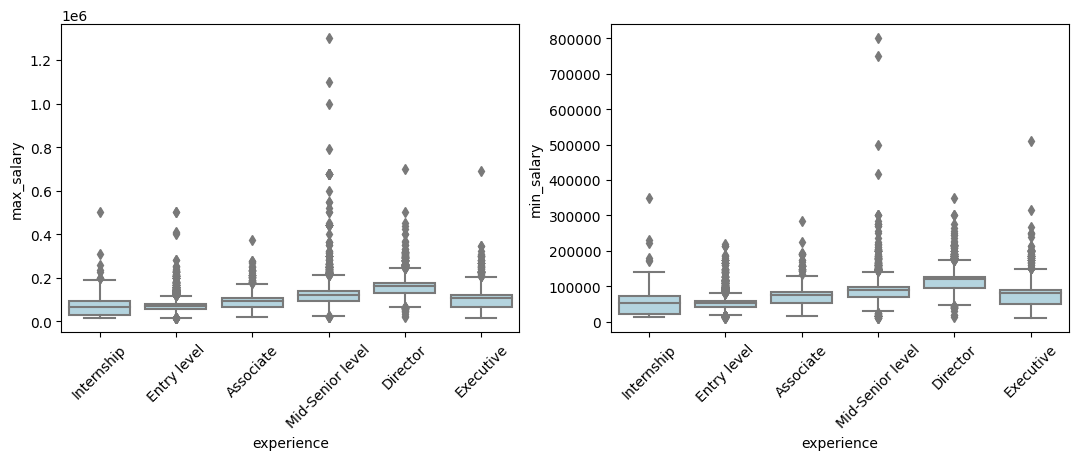

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.boxplot(x='experience', y='max_salary', data=base,  ax=ax[0], color ='lightblue', order=['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive'])
sns.boxplot(x='experience', y='min_salary', data=base,  ax=ax[1], color ='lightblue', order=['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive'])

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
plt.show()

Función para evaluar outliers severos para cada uno de los niveles de experiencia.

**Método basado en la Desviación Estándar:** Un valor que está a más de 2 o 3 desviaciones estándar de la media se puede considerar un outlier severo.

In [ ]:
def outliers(columna, experiencia):

    filtrado = base[base['experience']==experiencia]
    media = np.mean(filtrado[columna])
    desvest = np.std(filtrado[columna])

    num_desviaciones = 2

    # Calcular los límites superior e inferior
    limite_superior = media + (num_desviaciones * desvest)
    limite_inferior = media - (num_desviaciones * desvest)

    return limite_inferior, limite_superior

#### **Max Salary Outliers**

##### Internship

In [ ]:
columna, experiencia = 'max_salary', 'Internship'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  177062.79081626883
Limite inferior:  -28424.85619994525

Cantidad de registros por encima del límite:  9
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Entry level

In [ ]:
columna, experiencia = 'max_salary', 'Entry level'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  145707.52654134744
Limite inferior:  191.08818331969087

Cantidad de registros por encima del límite:  112
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Associate

In [ ]:
columna, experiencia = 'max_salary', 'Associate'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  178324.73941221565
Limite inferior:  12291.163643254651

Cantidad de registros por encima del límite:  40
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Mid-Senior level

In [ ]:
columna, experiencia = 'max_salary', 'Mid-Senior level'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  265353.65886818845
Limite inferior:  -11554.929072882805

Cantidad de registros por encima del límite:  64
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Director

In [ ]:
columna, experiencia = 'max_salary', 'Director'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  266261.5308513623
Limite inferior:  57264.2704761659

Cantidad de registros por encima del límite:  61
Cantidad de registros por debajo del límite:  10


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Executive

In [ ]:
columna, experiencia = 'max_salary', 'Executive'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  224586.4074792476
Limite inferior:  -6585.638235277947

Cantidad de registros por encima del límite:  51
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

#### **Min Salary Outliers**

##### Internship

In [ ]:
columna, experiencia = 'min_salary', 'Internship'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  129405.10236212629
Limite inferior:  -18636.53557896094

Cantidad de registros por encima del límite:  10
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Entry level

In [ ]:
columna, experiencia = 'min_salary', 'Entry level'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  101554.52106835306
Limite inferior:  6127.1247394203165

Cantidad de registros por encima del límite:  115
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Associate

In [ ]:
columna, experiencia = 'min_salary', 'Associate'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  130673.38214449232
Limite inferior:  16649.37157174843

Cantidad de registros por encima del límite:  30
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Mid-Senior level

In [ ]:
columna, experiencia = 'min_salary', 'Mid-Senior level'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  161360.1414652553
Limite inferior:  13967.650704662141

Cantidad de registros por encima del límite:  71
Cantidad de registros por debajo del límite:  5


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Director

In [ ]:
columna, experiencia = 'min_salary', 'Director'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  184270.34157142907
Limite inferior:  51356.601159228856

Cantidad de registros por encima del límite:  73
Cantidad de registros por debajo del límite:  23


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

##### Executive

In [ ]:
columna, experiencia = 'min_salary', 'Executive'
lower, upper = outliers(columna, experiencia)
print("Limite superior: ", upper)
print("Limite inferior: ", lower)

upper_rows = base[(base['experience'] == experiencia) & (base[columna] > upper)].shape[0]
print("\nCantidad de registros por encima del límite: ", upper_rows)

lower_rows = base[(base['experience'] == experiencia) & (base[columna] < lower)].shape[0]
print("Cantidad de registros por debajo del límite: ", lower_rows)

Limite superior:  169358.90465459143
Limite inferior:  -5339.201215994835

Cantidad de registros por encima del límite:  61
Cantidad de registros por debajo del límite:  0


In [ ]:
# Cambiar los valores por encima del límite por el límite
base.loc[(base['experience'] == experiencia) & (base[columna] > upper), 'max_salary'] = upper
base.loc[(base['experience'] == experiencia) & (base[columna] < lower), 'max_salary'] = lower

## Análisis del Salario

In [ ]:
df = base[['title', 'description', 'experience', 'max_salary', 'min_salary']]

In [ ]:
import plotly.express as px
fig = px.scatter(df, x="min_salary", y="max_salary", color="experience", log_x=True, size_max=60, title="Salaries by Experience Level")
fig.update_layout(width=1100, height=600)
fig.show()

In [ ]:
# calculo del salario promedio
def salariopromedio(a, b):
  ajustado=[]
  for x, y in zip(a,b):
    avg = (x+y)/2
    ajustado.append(avg)

  return ajustado

In [ ]:
df['avg_salary'] = salariopromedio(df['min_salary'], df['max_salary'])

### Distribución del salario

In [ ]:
df['avg_salary'].describe()

count     10379.000000
mean      91604.441105
std       40660.308749
min       14040.000000
25%       60313.066667
50%       85663.207547
75%      113157.811765
max      339679.452327
Name: avg_salary, dtype: float64

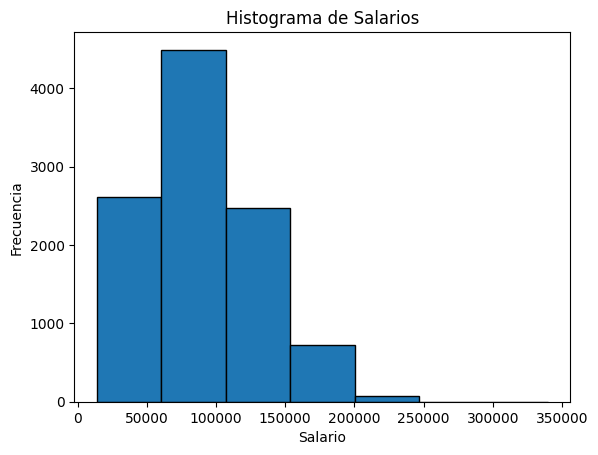

In [ ]:
plt.hist(df['avg_salary'], bins=7, edgecolor='k')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')
plt.title('Histograma de Salarios')
plt.show()

In [ ]:
import numpy as np

# Calcula los bordes de los bins y el histograma
hist, edges = np.histogram(df['avg_salary'], bins=7)

# Define el número de decimales al que deseas redondear los intervalos
decimales = 2  # Cambia esto al número deseado de decimales

print(f"Intervalos entre los bordes de los bins redondeados a {decimales} decimales:\n")
for i in range(len(edges) - 1):
    interval_start = round(edges[i], decimales)
    interval_end = round(edges[i + 1], decimales)
    count = hist[i]
    print(f"Del {interval_start} al {interval_end}: {count} valores")

Intervalos entre los bordes de los bins redondeados a 2 decimales:

Del 14040.0 al 60559.92: 2614 valores
Del 60559.92 al 107079.84: 4490 valores
Del 107079.84 al 153599.77: 2470 valores
Del 153599.77 al 200119.69: 725 valores
Del 200119.69 al 246639.61: 79 valores
Del 246639.61 al 293159.53: 0 valores
Del 293159.53 al 339679.45: 1 valores


In [ ]:
df['title'][df['avg_salary']>200000].unique()
# ejecutivos, directores o presidentes, no son outliers

array(['director sales market', 'president toa global north america',
       'head data science', 'associate medical director',
       'director engineer growth', 'director growth product',
       'svp group director digital strategy analytics', 'tax director',
       'senior manager cyber compliance',
       'crocs inc director ecommerce product management',
       'director business development drug product',
       'director solar engineer', 'senior manager digital market',
       'senior manager business intelligence amazon export',
       'senior associate compliance',
       'principal apply scientist aws market',
       'senior software engineer oncology',
       'senior manager commerce platform', 'director lifecycle market',
       'senior manager global brand market', 'director player engagement',
       'senior director field market',
       'director audio podcast advertise twitch advertise',
       'principal aws strategy business development',
       'senior staff princip

In [ ]:
df2 = df[df['avg_salary']<200000]

In [ ]:
import numpy as np

# Calcula los bordes de los bins y el histograma
hist, edges = np.histogram(df2['avg_salary'], bins=4)

# Define el número de decimales al que deseas redondear los intervalos
decimales = 2  # Cambia esto al número deseado de decimales

print(f"Intervalos entre los bordes de los bins redondeados a {decimales} decimales:\n")
for i in range(len(edges) - 1):
    interval_start = round(edges[i], decimales)
    interval_end = round(edges[i + 1], decimales)
    count = hist[i]
    print(f"Del {interval_start} al {interval_end}: {count} valores")

Intervalos entre los bordes de los bins redondeados a 2 decimales:

Del 14040.0 al 60438.79: 2610 valores
Del 60438.79 al 106837.59: 4493 valores
Del 106837.59 al 153236.38: 2470 valores
Del 153236.38 al 199635.17: 710 valores


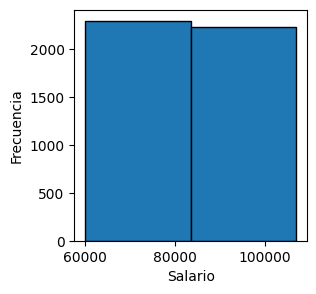

In [ ]:
# analizando el segundo intervalo, del 60521.15 al 107002.31
copia = df2[(df2['avg_salary']>60000) & (df2['avg_salary']<107000)]

plt.figure(figsize=(3, 3))
plt.hist(copia['avg_salary'], bins=2, edgecolor='k')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Define los límites de los bins y las etiquetas correspondientes
bins = [0, 60000, 80000, 100000, 120000, 150000, float('inf')]
labels = ['< 60 mil', 'entre 60 y 80 mil', 'entre 80 y 100 mil', 'entre 100 y 120 mil', 'entre 120 y 150 mil', '> 150 mil']

# Crea una nueva columna 'salary_range' con las etiquetas de rango
df['salary_range'] = pd.cut(df['avg_salary'], bins=bins, labels=labels)

In [ ]:
df['salary_range'].value_counts()

< 60 mil               2586
entre 60 y 80 mil      2107
entre 100 y 120 mil    1765
entre 80 y 100 mil     1544
entre 120 y 150 mil    1423
> 150 mil               954
Name: salary_range, dtype: int64

In [ ]:
df[['description', 'avg_salary', 'salary_range']]

,description,avg_salary,salary_range
0,license insurance agent many industries hurt last years people still need in...,48880.000000,< 60 mil
1,studio assistant could one magic makers ken fulk inc seek studio assistant m...,58478.573134,< 60 mil
2,office associate provide clerical administrative support management requeste...,39500.000000,< 60 mil
3,company owner hvac refrigeration technicians helpers need look someone exper...,141420.000000,entre 120 y 150 mil
4,commercial property manager senior property manager join grow property manag...,155648.946930,> 150 mil
...,...,...,...
10374,sanitation technician location west columbia 29172 29172 job type bakery ope...,46547.750000,< 60 mil
10375,unit secretary job title unit secretary department nurse report nurse manage...,81250.000000,entre 80 y 100 mil
10376,radiology aide perdiem job title radiology aide perdiem department cat scan ...,24925.904676,< 60 mil
10377,mri manager grade 105 job type officer administrationbargaining unit regular...,122500.000000,entre 120 y 150 mil


# Modelos

### Word2Vec Model

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    words = word_tokenize(text.lower())
    return words

df['processed_description'] = df['description'].apply(preprocess_text)

In [ ]:
from gensim.models import Word2Vec

# Entrenar el modelo Word2Vec
model = Word2Vec(sentences=df['processed_description'], vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
# Función para obtener el vector promedio de una descripción
def get_description_vector(description, model):
    words = preprocess_text(description)
    vectors = [model.wv[word] for word in words if word in model.wv]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * model.vector_size

# Crear una columna con los vectores de descripciones
df['description_vector'] = df['description'].apply(lambda x: get_description_vector(x, model))

In [ ]:
# Convertir las etiquetas de rango salarial a valores numéricos
salary_mapping = {
    '< 60 mil': 1,
    'entre 60 y 80 mil': 2,
    'entre 80 y 100 mil': 3,
    'entre 100 y 120 mil': 4,
    'entre 120 y 150 mil': 5,
    '> 150 mil': 6
}

df['salary_numeric'] = df['salary_range'].map(salary_mapping)

In [ ]:
# Separar los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['description_vector'], df['salary_numeric'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import normalize

# Normalizar vectores de descripción
X_train_normalized = normalize(X_train.tolist())
X_test_normalized = normalize(X_test.tolist())


In [ ]:
# Entrenar un modelo de regresión lineal
reg_model = LinearRegression()
reg_model.fit(X_train_normalized, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = reg_model.predict(X_test_normalized)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.489493704882266


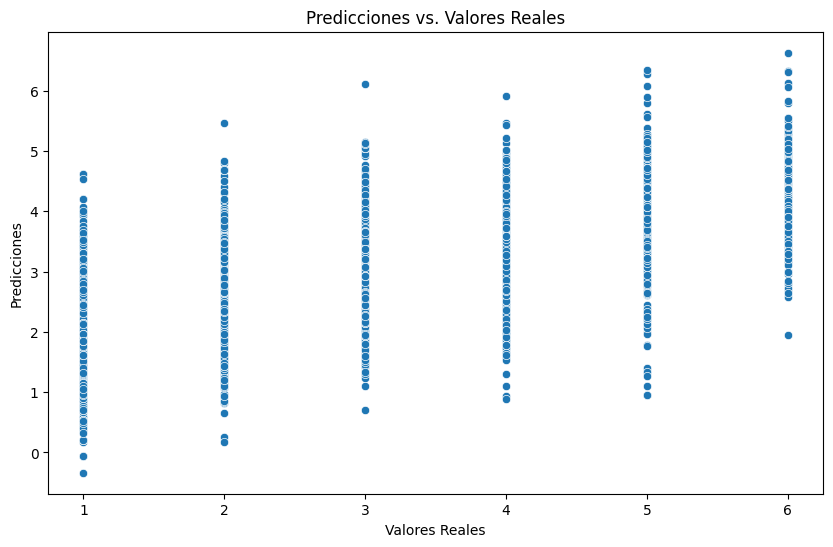

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


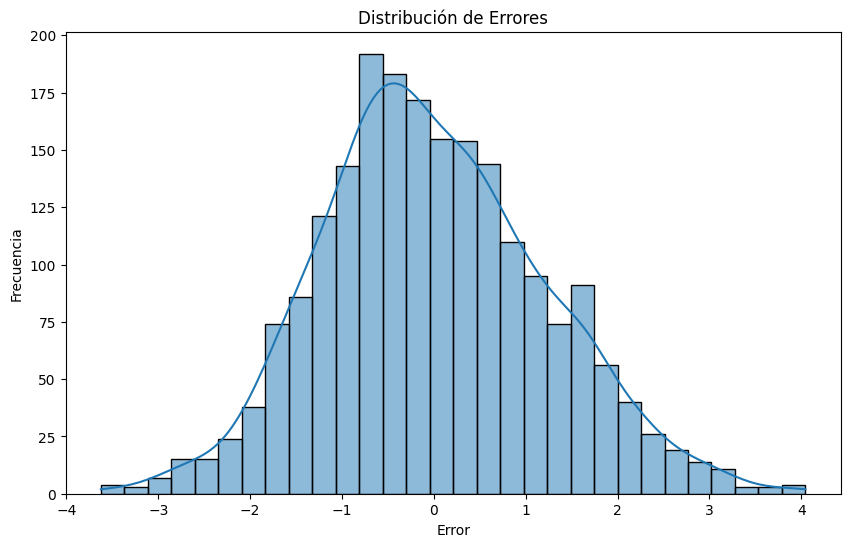

In [ ]:
# Convertir y_test a una lista
y_test_list = y_test.tolist()

# Calcular los errores
errors = y_test_list - predictions

# Gráfico de la distribución de errores
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribución de Errores')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()


Mean Squared Error (Random Forest): 1.271105372118194


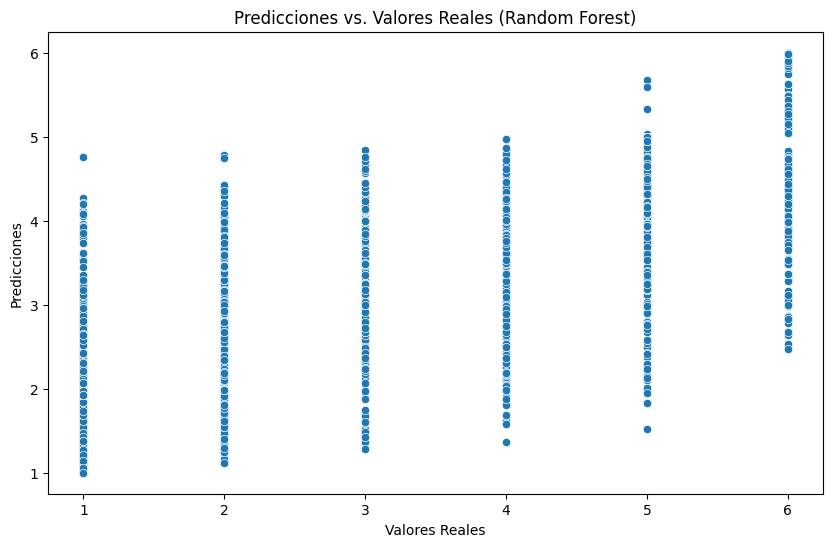

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar un modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_normalized, y_train)

# Realizar predicciones en el conjunto de prueba
rf_predictions = rf_model.predict(X_test_normalized)

# Evaluar el rendimiento del modelo de Random Forest
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Mean Squared Error (Random Forest): {rf_mse}')

# Gráfico de dispersión de predicciones vs. valores reales para Random Forest
rf_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=rf_results_df)
plt.title('Predicciones vs. Valores Reales (Random Forest)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

In [ ]:
from sklearn.svm import SVR

# Crear y entrenar un modelo SVR
svr_model = SVR()
svr_model.fit(X_train_normalized, y_train)

# Realizar predicciones
svr_predictions = svr_model.predict(X_test_normalized)
from sklearn.metrics import mean_squared_error

# Calcular el MSE para SVR
mse_svr = mean_squared_error(y_test, svr_predictions)
print(f'Mean Squared Error (SVR): {mse_svr}')

Mean Squared Error (SVR): 1.4135780509639522


In [ ]:
# Redondear las predicciones a los valores más cercanos de salario
rounded_predictions_linear = predictions.round()

# Calcular el porcentaje de predicciones correctas
accuracy_linear = (rounded_predictions_linear == y_test).mean() * 100
print(f'Porcentaje de Predicciones Correctas (Regresión Lineal): {accuracy_linear:.2f}%')


Porcentaje de Predicciones Correctas (Regresión Lineal): 31.31%


In [ ]:
# Redondear las predicciones de Random Forest
rounded_predictions_rf = rf_predictions.round()

# Calcular el porcentaje de predicciones correctas para Random Forest
accuracy_rf = (rounded_predictions_rf == y_test).mean() * 100
print(f'Porcentaje de Predicciones Correctas (Random Forest): {accuracy_rf:.2f}%')

Porcentaje de Predicciones Correctas (Random Forest): 41.28%


### GloVe Model

In [ ]:
!pip install gensim

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

# Ruta al archivo de GloVe y ruta de salida para el nuevo archivo Word2Vec
glove_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.word2vec'

# Convertir el archivo GloVe a formato Word2Vec
glove2word2vec(glove_file, word2vec_output_file)

# Cargar el modelo GloVe con Gensim
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

FileNotFoundError: ignored

In [ ]:
salary_mapping = {
    '< 60 mil': 1,
    'entre 60 y 80 mil': 2,
    'entre 80 y 100 mil': 3,
    'entre 100 y 120 mil': 4,
    'entre 120 y 150 mil': 5,
    '> 150 mil': 6
}

df['salary_numeric'] = df['salary_range'].map(salary_mapping)

In [ ]:
# Obtener las descripciones y los niveles de salario
descriptions = df['description'].tolist()
salaries = df['salary_numeric']

# Crear vectores para las descripciones
def get_average_vector(description, model):
    words = description.split()
    words_in_model = [word for word in words if word in model]
    vectors = [model[word] for word in words_in_model]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * model.vector_size  # Vector de ceros si no se encuentran palabras en el modelo

# Crear una lista de vectores de descripciones
description_vectors = [get_average_vector(desc, model) for desc in descriptions]

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(description_vectors, salaries, test_size=0.2, random_state=42)

# Crear un modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = rf.predict(X_test)

# Evaluar el modelo (por ejemplo, con la métrica de error absoluto medio)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print("Error absoluto medio en el conjunto de prueba:", mae)

Error absoluto medio en el conjunto de prueba: 0.8977406401268396


In [ ]:
# Evaluar el rendimiento del modelo
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.392047384334187


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print("Coeficiente de determinación (R2):", r2)

Coeficiente de determinación (R2): 0.47387914470448667


In [ ]:
# Redondear las predicciones de Random Forest
pred_rf = predictions.round()

# Calcular el porcentaje de predicciones correctas para Random Forest
accuracy_rf = (pred_rf == y_test).mean() * 100
print(f'Porcentaje de Predicciones Correctas (Random Forest): {accuracy_rf:.2f}%')

Porcentaje de Predicciones Correctas (Random Forest): 39.35%


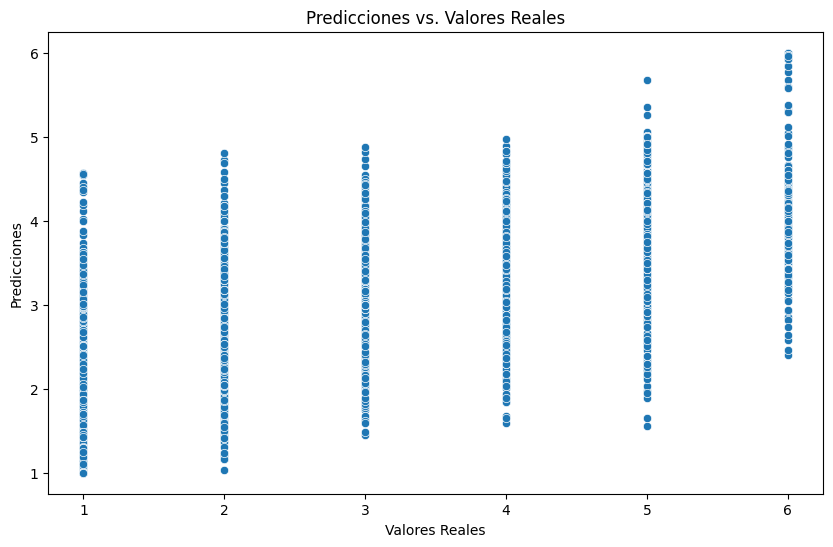

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

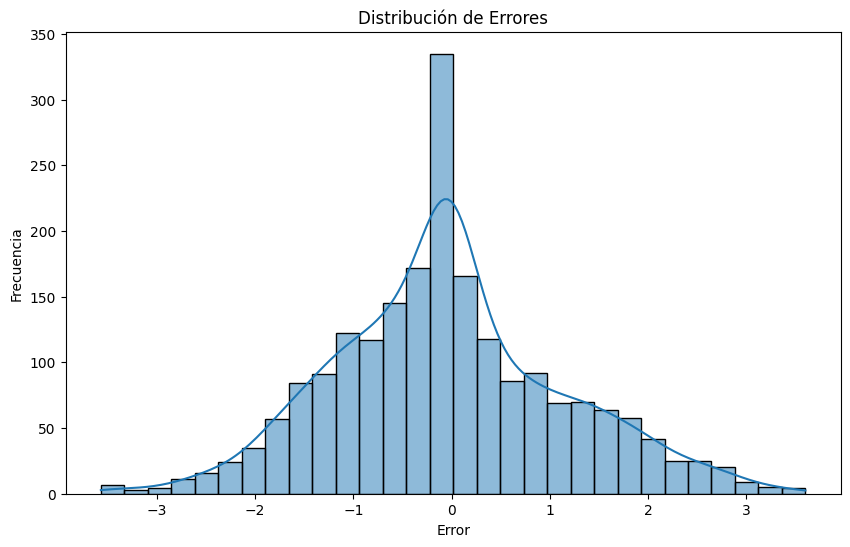

In [ ]:
# Convertir y_test a una lista
y_test_list = y_test.tolist()

# Calcular los errores
errors = y_test_list - predictions

# Gráfico de la distribución de errores
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribución de Errores')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [150, 200, 250],  # Prueba con diferentes cantidades de árboles
    'max_depth': [20, 30, 35, 45]  # Prueba con diferentes profundidades máximas de los árboles
}


# Utilizar GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo con los mejores hiperparámetros usando el conjunto de entrenamiento completo
best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
best_model.fit(X_train, y_train)

# Realizar predicciones con el mejor modelo en el conjunto de prueba
predictions2 = best_model.predict(X_test)

# Calcular R^2 con el mejor modelo
r2 = r2_score(y_test, predictions2)
print("Coeficiente de determinación (R^2) con el mejor modelo:", r2)

Mejores hiperparámetros: {'max_depth': 30, 'n_estimators': 250}
Coeficiente de determinación (R^2) con el mejor modelo: 0.4796666803689824


In [ ]:
# Redondear las predicciones de Random Forest
pred_rf_gs = predictions2.round()

# Calcular el porcentaje de predicciones correctas para Random Forest
accuracy_rf = (pred_rf_gs == y_test).mean() * 100
print(f'Porcentaje de Predicciones Correctas (Random Forest): {accuracy_rf:.2f}%')

Porcentaje de Predicciones Correctas (Random Forest): 39.16%


No mejora con el Grid Search

### Count Vectorizer Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
y_clase = df['salary_range']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_texto = df['description']
train_text, test_text, y_train_class, y_test_class = train_test_split(X_texto, y_clase, test_size=0.2, random_state=42)

In [ ]:
# Aplicar Count Vectorizer
vectorizador_contador = CountVectorizer()
X_train_counts = vectorizador_contador.fit_transform(train_text)
X_test_counts = vectorizador_contador.transform(test_text)

In [ ]:
# Aplicar TF-IDF Transformation
transformador_tfidf = TfidfTransformer()
X_train_tfidf = transformador_tfidf.fit_transform(X_train_counts)
X_test_tfidf = transformador_tfidf.transform(X_test_counts)

In [ ]:
# Clasificador Random Forest
clasificador_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clasificador_rf.fit(X_train_tfidf, y_train_class)
predicciones_rf = clasificador_rf.predict(X_test_tfidf)

In [ ]:
# Evaluar el clasificador Random Forest
precision_rf = accuracy_score(y_test_class, predicciones_rf)
print(f'Precisión del Clasificador Random Forest: {precision_rf}')

Precisión del Clasificador Random Forest: 0.5043352601156069


In [ ]:
# Clasificador SGD
clasificador_sgd = SGDClassifier(random_state=42)
clasificador_sgd.fit(X_train_tfidf, y_train_class)
predicciones_sgd = clasificador_sgd.predict(X_test_tfidf)

In [ ]:
# Evaluar el clasificador SGD
precision_sgd = accuracy_score(y_test_class, predicciones_sgd)
print(f'Precisión del Clasificador SGD: {precision_sgd}')

Precisión del Clasificador SGD: 0.4975915221579961


In [ ]:
# Clasificador SVM
clasificador_svm = SVC(random_state=42)
clasificador_svm.fit(X_train_tfidf, y_train_class)
predicciones_svm = clasificador_svm.predict(X_test_tfidf)

In [ ]:
# Evaluar el clasificador SVM
precision_svm = accuracy_score(y_test_class, predicciones_svm)
print(f'Precisión del Clasificador SVM: {precision_svm}')

Precisión del Clasificador SVM: 0.5351637764932563


In [ ]:
print('\nInforme del Clasificador Random Forest:')
print(classification_report(y_test_class, predicciones_rf))

print('\nInforme del Clasificador SGD:')
print(classification_report(y_test_class, predicciones_sgd))

print('\nInforme del Clasificador SVM:')
print(classification_report(y_test_class, predicciones_svm))


Informe del Clasificador Random Forest:
                     precision    recall  f1-score   support

           < 60 mil       0.52      0.84      0.64       509
          > 150 mil       0.64      0.48      0.55       163
entre 100 y 120 mil       0.44      0.45      0.44       371
entre 120 y 150 mil       0.65      0.40      0.49       293
  entre 60 y 80 mil       0.44      0.38      0.41       447
 entre 80 y 100 mil       0.47      0.31      0.37       293

           accuracy                           0.50      2076
          macro avg       0.53      0.47      0.48      2076
       weighted avg       0.51      0.50      0.49      2076


Informe del Clasificador SGD:
                     precision    recall  f1-score   support

           < 60 mil       0.59      0.78      0.67       509
          > 150 mil       0.47      0.60      0.53       163
entre 100 y 120 mil       0.43      0.40      0.41       371
entre 120 y 150 mil       0.48      0.44      0.46       293
  entre 6

## Mejora de hiperparamtros

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

parametros_svm = {'C': [0.1, 0.5, 1], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
X_train_tfidf_subset, _, y_train_class_subset, _ = train_test_split(X_train_tfidf, y_train_class, test_size=0.2, random_state=42)

clasificador_svm = SVC(random_state=42)

# Búsqueda de hiperparámetros con un rango reducido y un conjunto de datos reducido
grid_search_svm = GridSearchCV(clasificador_svm, parametros_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_tfidf_subset, y_train_class_subset)

mejores_parametros = grid_search_svm.best_params_
print("Mejores parámetros:", mejores_parametros)

In [ ]:
# mejores parametros
clasificador_svm = SVC(C = 100, kernel= 'rbf', gamma= 'scale', random_state=42)

clasificador_svm.fit(X_train_tfidf, y_train_class)
predicciones_svm = clasificador_svm.predict(X_test_tfidf)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test_class, predicciones_svm)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
report = classification_report(y_test_class, predicciones_svm)
print('Informe de clasificación:\n', report)

Precisión del modelo: 0.55
Informe de clasificación:
                      precision    recall  f1-score   support

           < 60 mil       0.68      0.66      0.67       479
          > 150 mil       0.69      0.45      0.54       164
entre 100 y 120 mil       0.57      0.48      0.52       384
entre 120 y 150 mil       0.44      0.58      0.50       235
  entre 60 y 80 mil       0.49      0.62      0.55       457
 entre 80 y 100 mil       0.48      0.38      0.43       329

           accuracy                           0.55      2048
          macro avg       0.56      0.53      0.53      2048
       weighted avg       0.56      0.55      0.55      2048



In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_tfidf.toarray())
X_test_normalized = scaler.transform(X_test_tfidf.toarray())
from sklearn.decomposition import PCA

# Aplicar PCA
num_componentes = 500  # ajusta el número de componentes según tus necesidades
pca = PCA(n_components=num_componentes)
# Aplicar PCA a los datos normalizados
pca = PCA(n_components=num_componentes)
X_train_pca_normalized = pca.fit_transform(X_train_normalized)
X_test_pca_normalized = pca.transform(X_test_normalized)

# Clasificador Random Forest con datos normalizados y PCA
clasificador_rf_normalized = RandomForestClassifier(n_estimators=100, random_state=42)
clasificador_rf_normalized.fit(X_train_pca_normalized, y_train_class)
predicciones_rf_normalized = clasificador_rf_normalized.predict(X_test_pca_normalized)

# Evaluar el clasificador Random Forest con datos normalizados y PCA
precision_rf_normalized = accuracy_score(y_test_class, predicciones_rf_normalized)
print(f'Precisión del Clasificador Random Forest con datos normalizados y PCA: {precision_rf_normalized}')

# Clasificador SGD con datos normalizados y PCA
clasificador_sgd_normalized = SGDClassifier(random_state=42)
clasificador_sgd_normalized.fit(X_train_pca_normalized, y_train_class)
predicciones_sgd_normalized = clasificador_sgd_normalized.predict(X_test_pca_normalized)

# Evaluar el clasificador SGD con datos normalizados y PCA
precision_sgd_normalized = accuracy_score(y_test_class, predicciones_sgd_normalized)
print(f'Precisión del Clasificador SGD con datos normalizados y PCA: {precision_sgd_normalized}')

# Clasificador SVM con datos normalizados y PCA
clasificador_svm_normalized = SVC(random_state=42)
clasificador_svm_normalized.fit(X_train_pca_normalized, y_train_class)
predicciones_svm_normalized = clasificador_svm_normalized.predict(X_test_pca_normalized)

# Evaluar el clasificador SVM con datos normalizados y PCA
precision_svm_normalized = accuracy_score(y_test_class, predicciones_svm_normalized)
print(f'Precisión del Clasificador SVM con datos normalizados y PCA: {precision_svm_normalized}')

# Mostrar informes de clasificación
print('\nInforme del Clasificador Random Forest con datos normalizados y PCA:')
print(classification_report(y_test_class, predicciones_rf_normalized))

print('\nInforme del Clasificador SGD con datos normalizados y PCA:')
print(classification_report(y_test_class, predicciones_sgd_normalized))

print('\nInforme del Clasificador SVM con datos normalizados y PCA:')
print(classification_report(y_test_class, predicciones_svm_normalized))
